In [1]:
# Cài đặt nếu chưa có
# !pip install pandas matplotlib seaborn wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz.fuzz import token_set_ratio
from underthesea import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.auto import tqdm
tqdm.pandas() # Kích hoạt progress bar cho pandas

# Cài đặt font chữ hỗ trợ Tiếng Việt cho Matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Các thư viện đã được import thành công!")


Các thư viện đã được import thành công!


In [2]:
# Đường dẫn tới file dữ liệu
DATA_PATH = '/home/guest/Projects/DSC2025/BAN/data/vihallu-train_processed.csv' # Thay 'train_set.csv' bằng tên file training thực tế của bạn

# Đọc dữ liệu
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Đọc thành công {len(df)} mẫu dữ liệu từ '{DATA_PATH}'")
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file tại '{DATA_PATH}'. Vui lòng kiểm tra lại đường dẫn.")
    df = None

if df is not None:
    # In ra 5 dòng đầu tiên
    print("\n5 dòng dữ liệu đầu tiên:")
    display(df.head())

    # In thông tin tổng quan (số lượng non-null, kiểu dữ liệu)
    print("\nThông tin chung về DataFrame:")
    df.info()

    # Kiểm tra xem có giá trị null nào không
    print("\nKiểm tra giá trị bị thiếu (null):")
    print(df.isnull().sum())


Đọc thành công 7000 mẫu dữ liệu từ '/home/guest/Projects/DSC2025/BAN/data/vihallu-train_processed.csv'

5 dòng dữ liệu đầu tiên:


,id,context,prompt,response,label
0,9b1ea51d-d1ff-45ba-8cf1-6a91328e8600,"Vào những năm 1870, hai nhà điêu khắc Augustus...","Vào những năm 1960, nơi nào trở thành trung tâ...",Quảng trường Washington là trung tâm của thế h...,extrinsic
1,db7a89c6-2a6a-42af-beef-58e557ecc819,Cách mạng Tháng Mười đã biến một cuộc chiến tr...,Cách mạng Tháng Mười đã khởi xướng chủ nghĩa p...,Sai. Cách mạng Tháng Mười đã đánh bại chủ nghĩ...,no
2,10fca062-d343-4eca-8434-93c7a8aa5e0e,Vị trí địa lý nằm giữa phương Đông và Địa Trun...,Dựa trên việc Đế quốc Ottoman không bao giờ ki...,Nền ẩm thực của Thổ Nhĩ Kỳ được xây dựng từ gi...,extrinsic
3,ece8eb9e-d6bb-407a-a567-d9531861c603,"Hồ Quý Ly trước có tên là Lê Quý Ly (黎季犛), biể...",Đời cháu thứ 12 của Hồ Hưng Dật sống ở đâu?,"Đời cháu thứ 12 của Hồ Hưng Dật, là Hồ Liêm, s...",no
4,b613217f-df2a-491e-8326-25811a31eb09,"Năm 2007, Bồ Đào Nha có khoảng 332.137 người n...","Từ thập niên 1990, tại sao xuất hiện một vài l...",Mặc dù Bồ Đào Nha đã đóng cửa biên giới hoàn t...,intrinsic



Thông tin chung về DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7000 non-null   object
 1   context   7000 non-null   object
 2   prompt    7000 non-null   object
 3   response  7000 non-null   object
 4   label     7000 non-null   object
dtypes: object(5)
memory usage: 273.6+ KB

Kiểm tra giá trị bị thiếu (null):
id          0
context     0
prompt      0
response    0
label       0
dtype: int64


In [3]:
df

,id,context,prompt,response,label
0,9b1ea51d-d1ff-45ba-8cf1-6a91328e8600,"Vào những năm 1870, hai nhà điêu khắc Augustus...","Vào những năm 1960, nơi nào trở thành trung tâ...",Quảng trường Washington là trung tâm của thế h...,extrinsic
1,db7a89c6-2a6a-42af-beef-58e557ecc819,Cách mạng Tháng Mười đã biến một cuộc chiến tr...,Cách mạng Tháng Mười đã khởi xướng chủ nghĩa p...,Sai. Cách mạng Tháng Mười đã đánh bại chủ nghĩ...,no
2,10fca062-d343-4eca-8434-93c7a8aa5e0e,Vị trí địa lý nằm giữa phương Đông và Địa Trun...,Dựa trên việc Đế quốc Ottoman không bao giờ ki...,Nền ẩm thực của Thổ Nhĩ Kỳ được xây dựng từ gi...,extrinsic
3,ece8eb9e-d6bb-407a-a567-d9531861c603,"Hồ Quý Ly trước có tên là Lê Quý Ly (黎季犛), biể...",Đời cháu thứ 12 của Hồ Hưng Dật sống ở đâu?,"Đời cháu thứ 12 của Hồ Hưng Dật, là Hồ Liêm, s...",no
4,b613217f-df2a-491e-8326-25811a31eb09,"Năm 2007, Bồ Đào Nha có khoảng 332.137 người n...","Từ thập niên 1990, tại sao xuất hiện một vài l...",Mặc dù Bồ Đào Nha đã đóng cửa biên giới hoàn t...,intrinsic
...,...,...,...,...,...
6995,ca2cfa61-c9ba-4923-b79e-def4af189ef8,Qua những hành động lừa dối bá tước Derby tại ...,Chiiến dịch muà hè đã tác động đếnn Edward như...,Chiến dịch mùa hè giúp Edward học hỏi từ những...,no
6996,26edc592-2a30-4bb8-956b-7764b7725f41,Tồn tại một số tranh chấp văn hóa giữa Malaysi...,"Để giải quyết tranh chấp văn hóa, Malaysia đã ...","Malaysia không chỉ nhượng bộ hoàn toàn, mà còn...",intrinsic
6997,c998fafc-6108-44b3-9bb5-dcd814e74013,Các triết gia Pháp sản sinh một số tác phẩm ch...,Mỹ dã ap dụn ly thuyet nào trong Tinh thần pha...,Nguyên tắc phân chia quyền lực được Mỹ áp dụng...,extrinsic
6998,a3c61cb3-2585-4c6f-bbe4-19a14ca7b09a,"Từ ""Yehudi"" (số nhiều Yehudim) trong tiếng Heb...",Từ Jeew trong tiếng Anh dc bắt nguồn từ tờ nào?,"Từ ""Jew"" trong tiếng Anh không chỉ bắt nguồn t...",extrinsic


In [4]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    TrainerCallback,
)
tokenizer = AutoTokenizer.from_pretrained("Viet-Mistral/Vistral-7B-Chat", trust_remote_code=True)

In [5]:
df['context']

0       Vào những năm 1870, hai nhà điêu khắc Augustus...
1       Cách mạng Tháng Mười đã biến một cuộc chiến tr...
2       Vị trí địa lý nằm giữa phương Đông và Địa Trun...
3       Hồ Quý Ly trước có tên là Lê Quý Ly (黎季犛), biể...
4       Năm 2007, Bồ Đào Nha có khoảng 332.137 người n...
                              ...                        
6995    Qua những hành động lừa dối bá tước Derby tại ...
6996    Tồn tại một số tranh chấp văn hóa giữa Malaysi...
6997    Các triết gia Pháp sản sinh một số tác phẩm ch...
6998    Từ "Yehudi" (số nhiều Yehudim) trong tiếng Heb...
6999    Các nguồn thu chính của việc thuế trực tiếp là...
Name: context, Length: 7000, dtype: object

In [20]:
df.iloc[89]

id                       0cdba62b-3069-45cb-8229-fe22905326bb
context     Đảo Wake do Không quân Hoa Kỳ quản lý dưới thỏ...
prompt      Dựa trên thông tin rằng Đảo Wake do Không quân...
response                                                  NaN
label                                                     NaN
Name: 89, dtype: object

In [6]:
contexts = df['context'] + ' ' + df['prompt']+ ' '+ df['response']
input_ids_list=[]
for i,context in enumerate(contexts):
    input_ids_list.append(len(tokenizer(context)['input_ids']))

In [7]:
max(input_ids_list)

1067

In [8]:
df.iloc[0]['id']

'9b1ea51d-d1ff-45ba-8cf1-6a91328e8600'

In [15]:
threshold = 150
count=0
for i,input_ids_len in enumerate(input_ids_list):
    if input_ids_len<threshold:
        print(f'idx {i} : {input_ids_len}', df.iloc[i]['id'])
        count+=1
print(count)

idx 3265 : 147 78bf380d-5710-4219-bff2-93576adce22d
1


In [21]:
print(df.iloc[3265]['label'])

no


750

In [71]:
input_ids_list[517]

802

In [ ]:
df.iloc[42][]

In [30]:
input_ids =tokenizer("Em là ai, từ đâu bước đến nơi đây dịu dàng chân phương")['input_ids']

In [41]:
input_ids

[1,
 2929,
 543,
 29891,
 11216,
 28725,
 34692,
 29891,
 33273,
 287,
 37233,
 33823,
 36852,
 34647,
 32154,
 32191,
 890,
 30906,
 28718,
 1866,
 33994,
 37401,
 32464]

In [40]:
list(input_ids).__len__()

23

In [44]:
tokenizer.batch_decode(input_ids)

['<s>',
 'Em',
 'la',
 '̀',
 'ai',
 ',',
 'tư',
 '̀',
 'đâu',
 'b',
 'ươ',
 '́c',
 'đê',
 '́n',
 'nơi',
 'đây',
 'di',
 '̣',
 'u',
 'da',
 '̀ng',
 'chân',
 'phương']

--- Phân tích Phân bổ Nhãn ---

Số lượng mẫu mỗi lớp:
label
intrinsic    2448
extrinsic    2307
no           2245
Name: count, dtype: int64


/tmp/ipykernel_453096/3884553107.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', order=['no', 'extrinsic', 'intrinsic'])


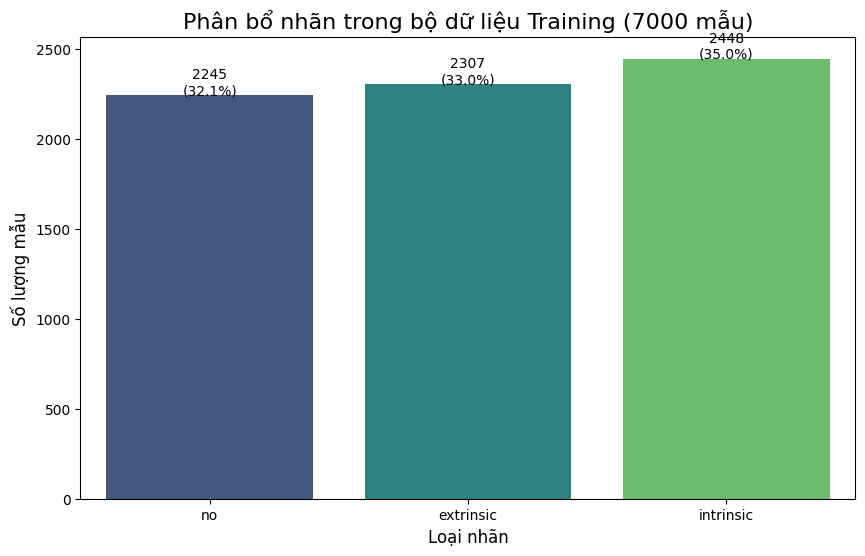


--- Tính toán Trọng số Lớp (Class Weights) ---
Trọng số tính toán cho mỗi lớp (để dùng trong PyTorch):
label
no           1.039347
extrinsic    1.011415
intrinsic    0.953159
Name: count, dtype: float64

List trọng số để đưa vào CrossEntropyLoss: [1.0393466963622866, 1.0114145354717525, 0.9531590413943355]


In [3]:
if df is not None:
    # 1. Phân tích phân bổ nhãn
    print("--- Phân tích Phân bổ Nhãn ---")
    label_counts = df['label'].value_counts()
    
    print("\nSố lượng mẫu mỗi lớp:")
    print(label_counts)

    # 2. Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', order=['no', 'extrinsic', 'intrinsic'])
    plt.title('Phân bổ nhãn trong bộ dữ liệu Training ({} mẫu)'.format(len(df)), fontsize=16)
    plt.xlabel('Loại nhãn', fontsize=12)
    plt.ylabel('Số lượng mẫu', fontsize=12)
    
    # Thêm số lượng trên mỗi cột
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}\n({p.get_height()/len(df):.1%})', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
    
    plt.show()

    # 3. Tính toán trọng số lớp (Class Weights)
    print("\n--- Tính toán Trọng số Lớp (Class Weights) ---")
    # Công thức: weight_c = TotalSamples / (NumClasses * count_c)
    # Đây là công thức phổ biến từ scikit-learn
    num_classes = len(label_counts)
    total_samples = len(df)
    
    weights = total_samples / (num_classes * label_counts)
    
    # Chuẩn hóa lại để trọng số của lớp nhỏ nhất là ~1.0 (tùy chọn, nhưng dễ nhìn)
    # normalized_weights = weights / weights.min()

    print("Trọng số tính toán cho mỗi lớp (để dùng trong PyTorch):")
    # Sắp xếp theo thứ tự label_id 0, 1, 2 ('no', 'extrinsic', 'intrinsic')
    label_map = {'no': 0, 'extrinsic': 1, 'intrinsic': 2}
    sorted_labels = sorted(label_map, key=label_map.get)
    class_weights_ordered = weights.loc[sorted_labels]

    print(class_weights_ordered)
    
    # Chuyển thành list để dễ dàng sử dụng trong PyTorch
    class_weights_list = class_weights_ordered.tolist()
    print(f"\nList trọng số để đưa vào CrossEntropyLoss: {class_weights_list}")



--- Phân tích Độ dài Văn bản (theo số từ) ---



Thống kê mô tả độ dài văn bản:


,context_len,prompt_len,response_len,combined_len
count,7000.000000,7000.000000,7000.000000,7000.000000
mean,179.695714,26.760714,39.476857,245.933286
std,72.473282,13.385212,10.264012,76.497955
min,88.000000,3.000000,1.000000,118.000000
50%,161.000000,26.000000,40.000000,230.000000
90%,264.000000,44.000000,52.000000,336.000000
95%,311.000000,50.000000,55.000000,380.000000
99%,405.050000,63.000000,60.000000,486.010000
max,1537.000000,94.000000,68.000000,1630.000000


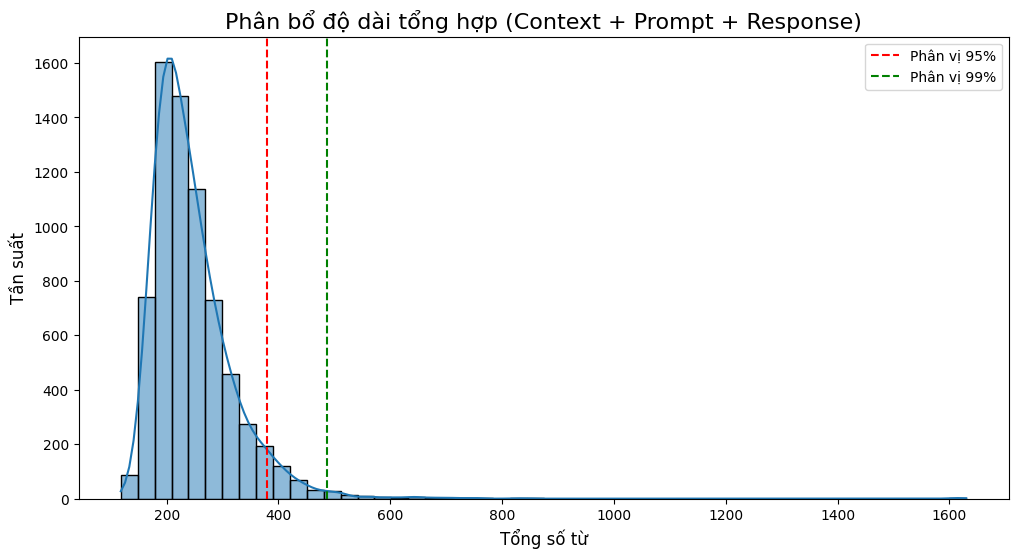

In [ ]:
if df is not None:
    print("\n--- Phân tích Độ dài Văn bản (theo số từ) ---")
    # Tính toán độ dài (bỏ qua các giá trị NaN nếu có)
    df['context_len'] = df['context'].dropna().str.split().str.len()
    df['prompt_len'] = df['prompt'].dropna().str.split().str.len()
    df['response_len'] = df['response'].dropna().str.split().str.len()
    df['combined_len'] = df['context_len'] + df['prompt_len'] + df['response_len']

    # In ra thống kê mô tả chi tiết
    print("\nThống kê mô tả độ dài văn bản:")
    display(df[['context_len', 'prompt_len', 'response_len', 'combined_len']].describe(percentiles=[.90, .95, .99]))

    # Vẽ biểu đồ phân bổ của độ dài tổng hợp
    plt.figure(figsize=(12, 6))
    sns.histplot(df['combined_len'], bins=50, kde=True)
    plt.title('Phân bổ độ dài tổng hợp (Context + Prompt + Response)', fontsize=16)
    plt.xlabel('Tổng số từ', fontsize=12)
    plt.ylabel('Tần suất', fontsize=12)
    plt.axvline(df['combined_len'].quantile(0.95), color='red', linestyle='--', label='Phân vị 95%')
    plt.axvline(df['combined_len'].quantile(0.99), color='green', linestyle='--', label='Phân vị 99%')
    plt.legend()
    plt.show()


In [ ]:
if df is not None:
    pd.set_option('display.max_colwidth', None) # Hiển thị toàn bộ nội dung cột

    print("\n--- Ví dụ cho nhãn 'intrinsic' (Mâu thuẫn) ---")
    display(df[df['label'] == 'intrinsic'].sample(2))

    print("\n--- Ví dụ cho nhãn 'extrinsic' (Bịa đặt) ---")
    display(df[df['label'] == 'extrinsic'].sample(2))
    
    print("\n--- Ví dụ về Prompt nhiễu (Noisy Prompt) ---")
    # Tìm các prompt có chứa ký tự đặc biệt hoặc có vẻ sai chính tả
    noisy_prompts = df[df['prompt'].str.contains('\?{2,}|[^\w\s\u00C0-\u1EF9,.]', regex=True, na=False)]
    display(noisy_prompts.sample(min(3, len(noisy_prompts))))



--- Ví dụ cho nhãn 'intrinsic' (Mâu thuẫn) ---


,id,context,prompt,response,label,context_len,prompt_len,response_len,combined_len
3448,342f60f7-5990-4327-b1c3-7a7208f227be,"Tháng 11 năm 1372, Trần Nghệ Tông xuống chiếu nhường ngôi cho em là Trần Kính, tức là Trần Duệ Tông, còn bản thân lên làm Thái thượng hoàng. Trần Duệ Tông là con của Đôn Từ thái phi, cũng là cô của Lê Quý Ly. Trần Duệ Tông lấy Lê Quý Ly làm Tham mưu quân sự. Năm 1376, vua Chiêm là Chế Bồng Nga lại mang quân xâm lấn. Duệ Tông sai Đỗ Tử Bình đi đánh. Chế Bồng Nga sợ hãi, xin dâng 10 mâm vàng tạ tội. Tử Bình giấu vàng đi, lại tâu về triều rằng vua Chiêm kiêu ngạo không thần phục. Duệ Tông quyết định thân chinh đi đánh. Tháng 12 năm 1376, Duệ Tông cầm 12 vạn quân đánh Chiêm Thành. Tháng giêng năm 1377, quân Đại Việt tiến vào cửa Thi Nại (Quy Nhơn), đánh lấy đồn Thạch Kiều rồi tiến tới kinh thành Đồ Bàn nước Chiêm. Quân Việt bị quân Chiêm phục kích, Duệ Tông tử trận. Lê Quý Ly bấy giờ đang đốc thúc quân tải lương, được tin Duệ Tông tử trận, sợ hãi, bỏ chạy về trước.","Vua Trần Nghệ Tông thoái vị vào tháng 11 năm 1372 để nhường ngôi cho con trai mình, phải không?","Trần Nghệ Tông thoái vị tháng 11 năm 1372, nhường ngôi cho em trai là Trần Duệ Tông, không phải con trai. Trong triều đại này, Trần Duệ Tông nổi tiếng vì liên minh chiến tranh với Lê Quý Ly, một chiến lược gia tài ba.",intrinsic,191,20,46,257
4309,dcd55c94-acfc-4143-b6fa-2bd6bb57efcc,"Như là Chủ tịch của ""Ủy ban Tên lửa von Neumann"" đầu tiên, và như là một thành viên của Commission for Atomic Energy sau này, bắt đầu từ 1953 cho đến cái chết của ông vào 1957, ông là khoa học gia với nhiều uy thế chính trị nhất ở Mỹ. Thông qua ủy ban của ông, ông phát triển nhiều tình huống khác nhau của việc chạy đua vũ trang hạt nhân, sự phát triển của các tên lửa liên lục địa và các tên lửa phóng lên từ tàu ngầm mang đầu đạn hạt nhân, và thế cân bằng chiến lược còn nhiều tranh cãi gọi là Chắc chắn Hủy diệt lẫn nhau (Mutually Assured Destruction). Có thể nói ông là bộ óc đằng sau các khía cạnh ""khoa học"" của Chiến tranh Lạnh đã tạo ra điều kiện trong bốn mươi năm của thế giới phương Tây.",Nguòi nào là nhà khoa học vói nhiều uy thế chín trị nhát ơ Mỹ z?,"Albert Einstein là nhà khoa học với nhiều uy thế chính trị nhất ở Mỹ, đặc biệt trong việc phát triển tên lửa liên lục địa và chiến lược Chắc chắn Hủy diệt lẫn nhau trong Chiến tranh Lạnh.",intrinsic,151,16,39,206



--- Ví dụ cho nhãn 'extrinsic' (Bịa đặt) ---


,id,context,prompt,response,label,context_len,prompt_len,response_len,combined_len
3873,a731c83b-80d9-4809-a18d-a1e72640e326,"Toàn tỉnh hiện có 2.086 km đường giao thông. Trong đó, đường do trung ương quản lý dài 224,38 km, chiếm 10,75%; đường do tỉnh quản lý dài 254,95 km, chiếm 12,21%; đường do huyện quản lý dài 327,47 km, chiếm 15,69% và đường do xã quản lý dài 1.566,97 km, chiếm 75%. Chất lượng đường bộ: Ðường cấp phối, đường đá dăm dài 399,52 km chiếm 19,14%; đường nhựa dài 362,77 km, chiếm 17,38% còn lại là đường đất. Tất cả các xã đã có đường ô tô đến tận trung tâm xã. Hiện nay, Nha Trang đang có 6 tuyến xe buýt phục vụ công cộng.","Độ dài đường giao thông tại Khánh Hòa do tỉnh quản lý có độ dài bao nhiêu, nếu biết rằng tổng chiều dài đường giao thông của tỉnh là 3.000 km?","Đường giao thông tại Khánh Hòa do tỉnh quản lý có độ dài 254,95 km. Ngoài ra, tỉnh Khánh Hòa còn nổi tiếng với bãi biển Nha Trang, một trong những điểm du lịch hấp dẫn nhất Việt Nam.",extrinsic,108,31,39,178
2240,95aad3be-5765-46ec-9602-36a1cd8ac9c5,"Thần học Ki-tô giáo là việc nghiên cứu niềm tin và thực hành đức tin Ki-tô giáo. Việc nghiên cứu như vậy trước hết tập trung vào các bản văn Cựu Ước và Tân Ước cúng như truyền thống Ki-tô giáo. Các nhà thần học Ki-tô giáo sử dụng các lời giải thích Kinh Thánh, các phân tích và tranh luận hợp lý. Thần học cũng có thể được thực hiện để giúp các nhà thần học hiểu rõ hơn các giáo lý Ki-tô giáo, để tạo nên sự so sánh giữa Ki-tô giáo với các truyền thống khác, để bảo vệ Ki-tô giáo trước những lời phản đối và phê bình, để làm dễ dàng hơn cho các sửa đổi bên trong Ki-tô giáo, để hỗ trợ cho việc rao giảng Ki-tô giáo, để đưa những cách thức của truyền thống Ki-tô giáo nhằm chuyển tải những tình huống hiện thời hay cần thiết, hoặc nhiều lý do khác.",Linh vuc nghien cuu cua thaan hoc Kito giaso la gi?,"Thần học Ki-tô giáo chủ yếu nghiên cứu các tác phẩm triết học Hy Lạp cổ đại để hiểu rõ hơn về các giáo lý và thực hành của đạo Phật, tập trung vào việc so sánh với các truyền thống phi Ki-tô giáo.",extrinsic,160,11,44,215



--- Ví dụ về Prompt nhiễu (Noisy Prompt) ---


,id,context,prompt,response,label,context_len,prompt_len,response_len,combined_len
3966,53110cbd-1bc1-4ae3-8161-aeb77492239d,"Năm 1952, như một phần của các cuộc cải cách để tập trung quyền lực trong tay Bộ chính trị của SED, năm Länder của Đông Đức bị xoá bỏ, và Đông Đức được chia thành mười lăm Bezirke (tỉnh), mỗi quận được đặt theo tên thành phố lớn nhất của nó: vùng Đất phía bắc Mecklenburg-Vorpommern được chia giữa Bezirke Rostock, Schwerin và Neubrandenburg; Brandenburg (bao quanh Berlin) được tái tổ chức thành Bezirke Potsdam, Frankfurt và Cottbus; Saxony-Anhalt được chia thành Bezirke Halle và Magdeburg; vùng Đất tây nam Thuringia thành Bezirke Erfurt, Gera và Suhl; cuối cùng, vùng Đất đông nam Sachsen được chia giữa Leipzig, Dresden và Karl-Marx-Stadt (trước kia và sau khi Cộng hoà Dân chủ Đức sụp đổ lại được gọi là Chemnitz). Thủ đô Cộng hoà Dân chủ Đức, Đông Berlin trở thành Bezirk thứ 15, dù nó vẫn giữ vị thế luật pháp đặc biệt trong Cộng hoà Dân chủ Đức cho tới năm 1968, khi những người dân Đông Berlin cùng toàn bộ người dân Cộng hoà Dân chủ Đức thông qua dự thảo hiến pháp mới. Từ thời điểm này trở về sau, bất chấp Vị thế Bốn Cường quốc và những sự phản đối của đồng minh phương Tây rằng Đông Berlin chỉ đơn giản là khu vực chiếm đóng của Xô viết tại thủ đô Đức, Đông Berlin được coi như một Bezirk như các tỉnh khác.",Gera laf noiw thuocj khu vuc nao?,"Gera hiện thuộc vùng đất đông nam Sachsen, nơi nó được chia cùng với Leipzig, Dresden và Karl-Marx-Stadt, tạo thành một phần của cấu trúc hành chính mới từ năm 1952.",intrinsic,239,7,31,277
3873,a731c83b-80d9-4809-a18d-a1e72640e326,"Toàn tỉnh hiện có 2.086 km đường giao thông. Trong đó, đường do trung ương quản lý dài 224,38 km, chiếm 10,75%; đường do tỉnh quản lý dài 254,95 km, chiếm 12,21%; đường do huyện quản lý dài 327,47 km, chiếm 15,69% và đường do xã quản lý dài 1.566,97 km, chiếm 75%. Chất lượng đường bộ: Ðường cấp phối, đường đá dăm dài 399,52 km chiếm 19,14%; đường nhựa dài 362,77 km, chiếm 17,38% còn lại là đường đất. Tất cả các xã đã có đường ô tô đến tận trung tâm xã. Hiện nay, Nha Trang đang có 6 tuyến xe buýt phục vụ công cộng.","Độ dài đường giao thông tại Khánh Hòa do tỉnh quản lý có độ dài bao nhiêu, nếu biết rằng tổng chiều dài đường giao thông của tỉnh là 3.000 km?","Đường giao thông tại Khánh Hòa do tỉnh quản lý có độ dài 254,95 km. Ngoài ra, tỉnh Khánh Hòa còn nổi tiếng với bãi biển Nha Trang, một trong những điểm du lịch hấp dẫn nhất Việt Nam.",extrinsic,108,31,39,178
6385,4bb6108c-ff78-4d79-8d9b-df350a274766,"Vì không có nhà kiến trúc nào được nhắc đến trong văn kiện chi tiết về công trình này, nhà sử học quân sự Allen Brown đã gợi ý rằng chính Richard là kiến trúc sư trưởng của công trình; điều này được hỗ trợ bởi niềm đam mê mà Richard dành cho công trình qua sự hiện diện thường xuyên của ông. Trong những năm cuối đời, lâu đài này trở thành dinh thự yêu thích của Richard, và các mệnh lệnh và biên bản được viết ở Château Gaillard đều ghi ""tại lâu đài tráng lệ trên vách đá"" (at the Fair Castle of the Rock). Château Gaillard đã đi trước thời đại, mang nhiều đổi mới mà cho tới gần một thế kỷ sau vẫn được sử dụng. Richard sau này khoe khoang rằng ông vẫn có thể giữ lâu đài ""dù cho tường thành có làm bằng bơ"". Allen Brown mô tả Château Gaillard như là ""một trong những lâu đài vững chắc nhất châu Âu"", còn nhà sử học quân sự Charles Oman viết:","Trong những năm cuối đời, Richard đã dành nhiều thời gian tại Château Gaillard, nơi ông thường xuyên lui tới và thậm chí còn khẳng định có thể giữ được lâu đài này ""dù cho tường thành có làm bằng bơ"", mặc dù thực tế là ông không bao giờ thực sự sống ở đó. Vậy, liệu có đúng rằng Richard không bao giờ coi Château Gaillard là nơi yêu thích của mình?","Không, điều đó không đúng. Trong những năm cuối đời, Château Gaillard trở thành dinh thự yêu thích của Richard, ông thường xuyên lui tới và thể hiện niềm đam mê dành cho công trình này.",no,179,73,36,288



--- Phân tích Độ tương đồng văn bản (Token Set Ratio) ---


  0%|          | 0/7000 [00:00<?, ?it/s]

/tmp/ipykernel_184049/1896374737.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='similarity_score', data=df, order=['no', 'intrinsic', 'extrinsic'], palette='coolwarm')


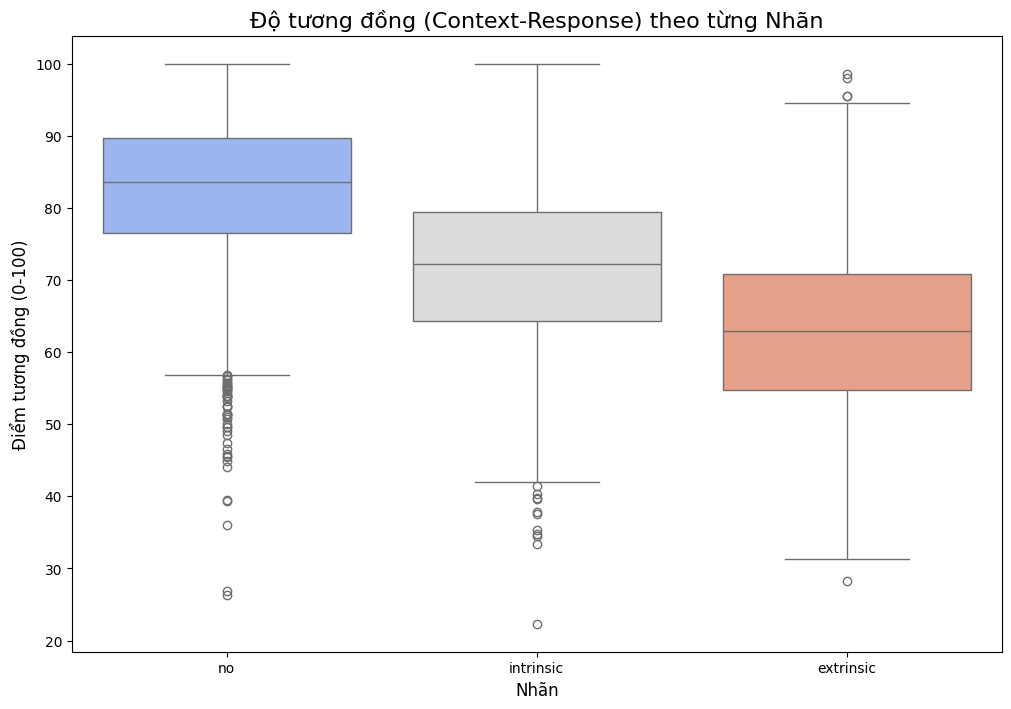


👉 Insight:
- Lớp 'no' có độ tương đồng cao và ổn định nhất, vì câu trả lời bám sát context.
- Lớp 'intrinsic' có độ tương đồng khá cao nhưng phân tán, vì nó vẫn dùng từ trong context nhưng 'bóp méo' chúng.
- Lớp 'extrinsic' có độ tương đồng thấp nhất, vì nó 'bịa' thêm thông tin mới.
=> Độ tương đồng là một feature rất mạnh để phân biệt các lớp!


In [ ]:
if df is not None:
    print("\n--- Phân tích Độ tương đồng văn bản (Token Set Ratio) ---")

    # Tính toán độ tương đồng giữa context và response
    # token_set_ratio rất hiệu quả vì nó bỏ qua thứ tự từ và từ lặp lại
    df['similarity_score'] = df.progress_apply(
        lambda row: token_set_ratio(str(row['context']), str(row['response'])),
        axis=1
    )

    # Vẽ biểu đồ boxplot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='label', y='similarity_score', data=df, order=['no', 'intrinsic', 'extrinsic'], palette='coolwarm')
    plt.title('Độ tương đồng (Context-Response) theo từng Nhãn', fontsize=16)
    plt.xlabel('Nhãn', fontsize=12)
    plt.ylabel('Điểm tương đồng (0-100)', fontsize=12)
    plt.show()

    print("\n👉 Insight:")
    print("- Lớp 'no' có độ tương đồng cao và ổn định nhất, vì câu trả lời bám sát context.")
    print("- Lớp 'intrinsic' có độ tương đồng khá cao nhưng phân tán, vì nó vẫn dùng từ trong context nhưng 'bóp méo' chúng.")
    print("- Lớp 'extrinsic' có độ tương đồng thấp nhất, vì nó 'bịa' thêm thông tin mới.")
    print("=> Độ tương đồng là một feature rất mạnh để phân biệt các lớp!")



--- Phân tích sự xuất hiện của 'Số Mới' trong Response ---


  0%|          | 0/7000 [00:00<?, ?it/s]

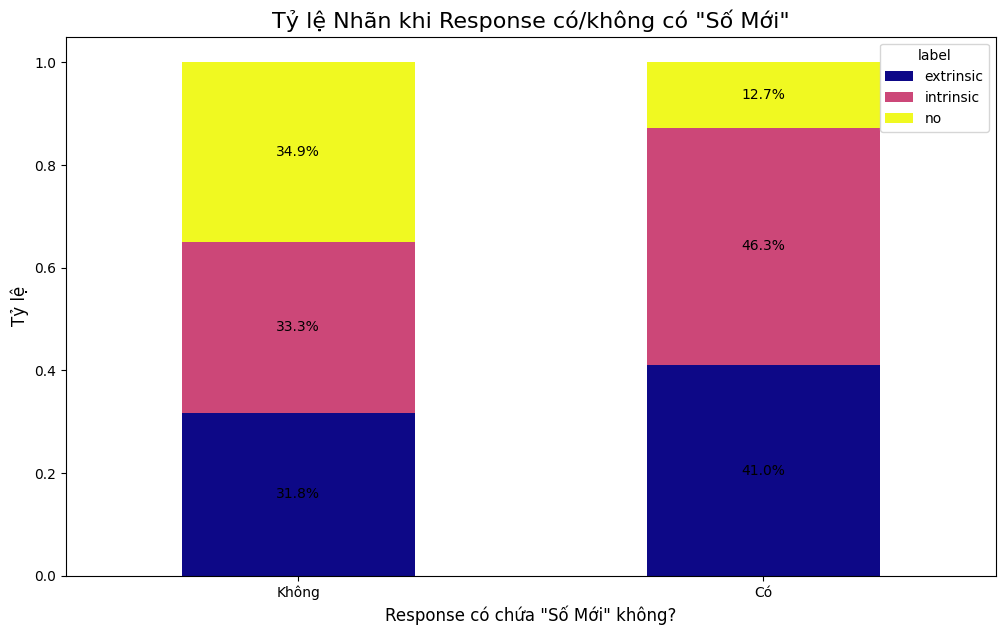


👉 Insight:
Khi response KHÔNG chứa số mới, phần lớn là nhãn 'no'.
Khi response CÓ chứa số mới, tỷ lệ ảo giác (đặc biệt là 'intrinsic' và 'extrinsic') tăng vọt.
=> Feature 'has_new_number' là một tín hiệu cực kỳ mạnh để phát hiện hallucination.


In [ ]:
import re

def count_new_numbers(row):
    """Đếm số lượng các con số chỉ xuất hiện trong response."""
    # Regex để tìm tất cả các chuỗi số (bao gồm cả dấu phẩy, chấm)
    context_numbers = set(re.findall(r'\b\d[\d,.]*\b', str(row['context'])))
    response_numbers = set(re.findall(r'\b\d[\d,.]*\b', str(row['response'])))
    
    # Trả về số lượng số trong response mà không có trong context
    return len(response_numbers - context_numbers)

if df is not None:
    print("\n--- Phân tích sự xuất hiện của 'Số Mới' trong Response ---")
    df['new_numbers_count'] = df.progress_apply(count_new_numbers, axis=1)

    # Tạo một cột boolean để phân tích dễ hơn
    df['has_new_number'] = df['new_numbers_count'] > 0

    # Vẽ biểu đồ crosstab
    crosstab = pd.crosstab(df['has_new_number'], df['label'], normalize='index')
    
    ax = crosstab.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='plasma', rot=0)
    plt.title('Tỷ lệ Nhãn khi Response có/không có "Số Mới"', fontsize=16)
    plt.xlabel('Response có chứa "Số Mới" không?', fontsize=12)
    plt.ylabel('Tỷ lệ', fontsize=12)
    plt.xticks([0, 1], ['Không', 'Có'])

    # Thêm chú thích phần trăm
    for c in ax.containers:
        ax.bar_label(c, fmt='{:.1%}', label_type='center')
        
    plt.show()

    print("\n👉 Insight:")
    print("Khi response KHÔNG chứa số mới, phần lớn là nhãn 'no'.")
    print("Khi response CÓ chứa số mới, tỷ lệ ảo giác (đặc biệt là 'intrinsic' và 'extrinsic') tăng vọt.")
    print("=> Feature 'has_new_number' là một tín hiệu cực kỳ mạnh để phát hiện hallucination.")



--- Phân tích ảnh hưởng của 'Prompt Gài bẫy' ---


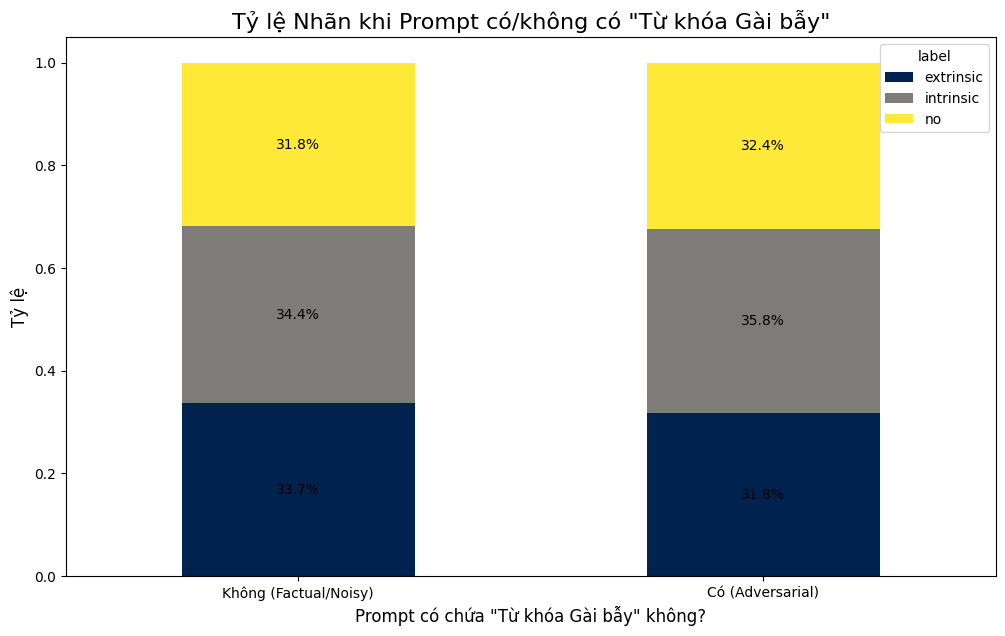


👉 Insight:
Các prompt 'gài bẫy' có xu hướng làm tăng nhẹ tỷ lệ ảo giác, đặc biệt là 'intrinsic'.
Điều này cho thấy mô hình cần học cách tin tưởng 'context' hơn là các tiền đề sai trong 'prompt'.


In [ ]:
ADVERSARIAL_KEYWORDS = [
    "mặc dù", "thực sự", "đúng không", "phải không", "đúng hay sai", 
    "có phải", "vốn không", "ngoài... ra", "thay vì"
]

def has_adversarial_keyword(prompt):
    prompt_lower = str(prompt).lower()
    return any(keyword in prompt_lower for keyword in ADVERSARIAL_KEYWORDS)

if df is not None:
    print("\n--- Phân tích ảnh hưởng của 'Prompt Gài bẫy' ---")
    df['is_adversarial_prompt'] = df['prompt'].apply(has_adversarial_keyword)

    crosstab_prompt = pd.crosstab(df['is_adversarial_prompt'], df['label'], normalize='index')
    
    ax = crosstab_prompt.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='cividis', rot=0)
    plt.title('Tỷ lệ Nhãn khi Prompt có/không có "Từ khóa Gài bẫy"', fontsize=16)
    plt.xlabel('Prompt có chứa "Từ khóa Gài bẫy" không?', fontsize=12)
    plt.ylabel('Tỷ lệ', fontsize=12)
    plt.xticks([0, 1], ['Không (Factual/Noisy)', 'Có (Adversarial)'])
    
    for c in ax.containers:
        ax.bar_label(c, fmt='{:.1%}', label_type='center')
        
    plt.show()
    
    print("\n👉 Insight:")
    print("Các prompt 'gài bẫy' có xu hướng làm tăng nhẹ tỷ lệ ảo giác, đặc biệt là 'intrinsic'.")
    print("Điều này cho thấy mô hình cần học cách tin tưởng 'context' hơn là các tiền đề sai trong 'prompt'.")


In [ ]:
def get_top_ngrams(corpus, n=2, top_k=15):
    """Trích xuất các n-gram phổ biến nhất từ một kho văn bản."""
    vec = CountVectorizer(ngram_range=(n, n), stop_words=None).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

if df is not None:
    print("\n--- Phân tích N-gram phổ biến trong Response bị lỗi ---")
    
    # Lọc ra các response của từng loại lỗi
    intrinsic_responses = df[df['label'] == 'intrinsic']['response'].dropna()
    extrinsic_responses = df[df['label'] == 'extrinsic']['response'].dropna()

    # Lấy top bi-grams (cụm 2 từ)
    top_intrinsic_bigrams = get_top_ngrams(intrinsic_responses, n=2)
    top_extrinsic_bigrams = get_top_ngrams(extrinsic_responses, n=2)

    # Tạo DataFrame để hiển thị
    df_bigrams = pd.DataFrame({
        'Top Intrinsic Bi-grams': [f"{gram} ({count})" for gram, count in top_intrinsic_bigrams],
        'Top Extrinsic Bi-grams': [f"{gram} ({count})" for gram, count in top_extrinsic_bigrams]
    })
    
    print("\nTop 15 Bi-grams (cụm 2 từ) phổ biến nhất:")
    display(df_bigrams)

    print("\n👉 Insight:")
    print("Phân tích n-gram có thể hé lộ các 'cụm từ ảo giác' phổ biến mà mô hình sinh ra.")
    print("Ví dụ: 'Ngoài ra', 'Thực tế', 'Tuy nhiên' có thể là dấu hiệu bắt đầu của một câu 'bịa' thêm (extrinsic).")



--- Phân tích N-gram phổ biến trong Response bị lỗi ---

Top 15 Bi-grams (cụm 2 từ) phổ biến nhất:


,Top Intrinsic Bi-grams,Top Extrinsic Bi-grams
0,hoàn toàn (313),nổi tiếng (371)
1,vào năm (276),phát triển (299)
2,mặc dù (255),vào năm (261)
3,không có (255),tiếng với (237)
4,điều này (253),không chỉ (224)
5,phát triển (241),điều này (222)
6,và không (190),mà còn (213)
7,không phải (177),ảnh hưởng (201)
8,quốc gia (176),tổ chức (198)
9,bất kỳ (171),mặc dù (198)



👉 Insight:
Phân tích n-gram có thể hé lộ các 'cụm từ ảo giác' phổ biến mà mô hình sinh ra.
Ví dụ: 'Ngoài ra', 'Thực tế', 'Tuy nhiên' có thể là dấu hiệu bắt đầu của một câu 'bịa' thêm (extrinsic).



--- Phân tích Sâu Lớp 'extrinsic' ---


Analyzing extrinsic sentences:   0%|          | 0/2307 [00:00<?, ?it/s]

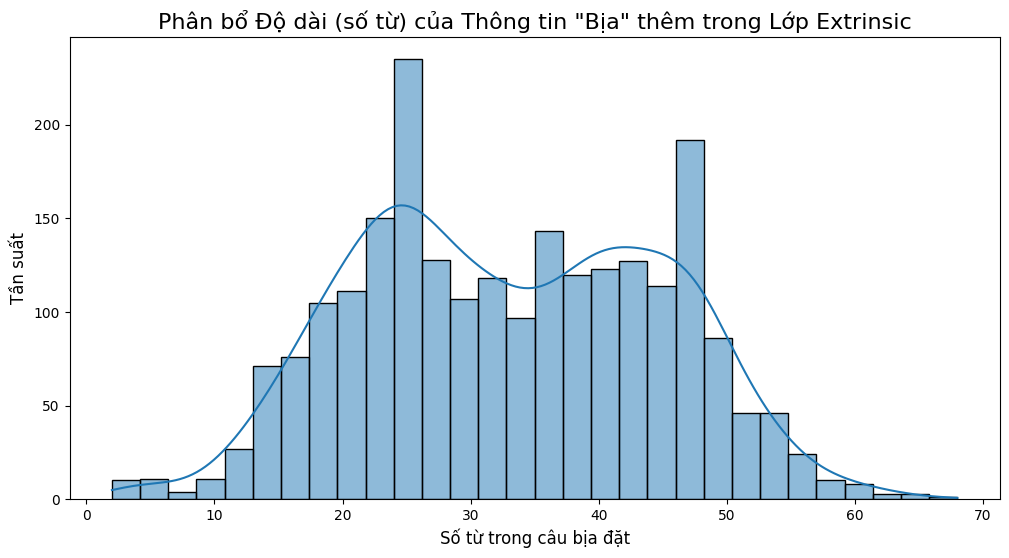


Ví dụ các câu 'bịa đặt' ngắn nhất được tìm thấy:


,context,response,hallucinated_sentence
5626,"Ngày 2 tháng 4 năm 1921, Chính phủ Trung Hoa Dân Quốc (Quảng Châu) được thành lập, Tôn Trung Sơn nhậm chức ""đại tổng thống phi thường"", lần đầu tiên sử dụng ""Thanh Thiên Bạch Nhật Mãn Địa Hồng kỳ"" làm quốc kỳ, nhằm phản đối tính hợp pháp của Chính phủ Bắc Dương, đến năm sau do Vận động Hộ pháp lần thứ hai thất bại nên giải thể. Ngày 2 tháng 3 năm 1923, Tôn Trung Sơn về Quảng Châu lập Đại bản doanh Đại nguyên soái Lục-Hải quân, tái lập chính phủ quân sự; đến ngày 1 tháng 7 năm 1925, cải tổ thành Chính phủ Quốc dân Trung Hoa Dân Quốc, sau khi Bắc phạt thành công thay thế Chính phủ Bắc Dương làm chính phủ trung ương và cơ quan hành chính tối cao của Trung Hoa Dân Quốc. Ngày 20 tháng 5 năm 1948, Chính phủ Quốc dân cải tổ thành Chính phủ Trung Hoa Dân Quốc, chức vụ Chủ tịch Chính phủ Quốc dân đổi thành ""Tổng thống"", duy trì đến nay.","Không đúng. Sau Bắc phạt, Chính phủ Quốc dân Trung Hoa Dân Quốc không phải là một phần của Chính phủ Bắc Dương mà thực tế đã thay thế Chính phủ Bắc Dương trở thành chính phủ trung ương. Ngoài ra, Tôn Trung Sơn từng được gọi là ""Cha đẻ của Trung Quốc hiện đại"".",Không đúng.
355,"Ngày 16 tháng 6 năm 1953, sau một quota sản xuất tăng 10% công nhân xây dựng đại lộ mới ở Đông Berlin, Stalinallee (ngày nay được gọi là Karl-Marx-Allee), những cuộc tuần hành của các công nhân bất bình nổ ra ở Đông Berlin. Ngày hôm sau những cuộc biểu tình phản kháng lan khắp Đông Đức với hơn một triệu người đình công và biểu tình trong 700 cộng đồng. Lo sợ một cuộc bạo động, chính phủ yêu cầu quân đội chiếm đóng Xô viết trợ giúp và vào buổi sáng ngày 18 xe tăng cùng binh sĩ được triển khai trấn áp những người biểu tình. Nhưng bạo động vẫn nổ ra, làm khoảng năm mươi người chết và một làn sóng bắt giữ, bỏ tù lên tới hơn 10.000 người. Sự quá cảnh giữa Tây và Đông Berlin là khá tự do ở thời điểm ấy, có nghĩa rằng những người biểu tình và những hành động trấn áp biểu tình của Liên Xô đã được nhiều nhà quan sát phương Tây ghi nhận.","Không đúng. Chính phủ Đông Đức đã yêu cầu sự trợ giúp của quân đội Xô viết để trấn áp người biểu tình, dẫn đến việc triển khai xe tăng và binh sĩ vào ngày 18 tháng 6 năm 1953.",Không đúng.
5153,"Trong tháng 6 năm 1940, sau khi Pháp thất thủ trước quân Đức, Hội đồng toàn thể Nouvelle-Calédonie nhất trí ủng hộ chính phủ Pháp quốc Tự do, và đến tháng 9 vị thống đốc thân Vichy bị buộc phải rời đến Đông Dương. Trong tháng 3 năm 1942, được Úc giúp đỡ, lãnh thổ trở thành một căn cứ quan trọng của Đồng Minh, và Nouméa là đại bản quan của lực lượng hải quân và lục quân của Hoa Kỳ tại Nam Thái Bình Dương. Hạm đội từng đẩy lui lực lượng hải quân của Nhật Bản trong trận chiến biển Coral vào tháng 5 năm 1942 có căn cứ tại Nouméa. Số lượng binh sĩ Hoa Kỳ đông đến 50.000, tương đương dân số lãnh thổ vào đương thời.","Không đúng. Sau khi Pháp thất thủ trước Đức, Nouvelle-Calédonie đã nhất trí ủng hộ chính phủ Pháp quốc Tự do và trở thành căn cứ quan trọng của Đồng Minh trong Thế chiến II.",Không đúng.
1414,"Chính phủ Cuba thường xuyên cử các đoàn y tế tới các khu vực có thiên tai, dịch bệnh trên thế giới (đặc biệt tại các nước nghèo) để hỗ trợ Kể từ khi Cuba cử một nhóm bác sĩ đến giúp Chile khắc phục hậu quả của một trận động đất năm 1960, đến nay Cuba này đã gửi hơn 135.000 nhân viên y tế đến nhiều nơi trên thế giới trong các sứ mệnh nhân đạo. ""Ngoại giao y tế"" tạo ra lợi ích sức khỏe và cải thiện quan hệ giữa các quốc gia là nền tảng của chính sách đối ngoại Cuba trong suốt hàng chục năm qua. Bên cạnh những giá trị về nhân đạo và tạo lập hình ảnh quốc gia, Cuba cũng được hưởng lợi kinh tế từ chính sách “ngoại giao y tế”. Cùng với các dịch vụ giáo dục, thể thao, việc cử các chuyên gia y tế ra nước ngoài làm việc đưa về cho Cuba khoảng 10 tỷ USD hàng năm, trở thành nguồn thu nhập quan trọng nhất đối với hòn đảo này.","Không đúng. 135.000 là số lượng nhân viên y tế mà Cuba đã cử đi giúp đỡ kể từ khi gửi nhóm bác sĩ đầu tiên đến Chile năm 1960, không phải từ năm 1


👉 Insight:
Biểu đồ này cho thấy mô hình phải đối mặt với các lỗi 'extrinsic' ở mọi độ dài.
Nếu biểu đồ lệch về bên trái (nhiều câu ngắn), điều đó xác nhận rằng các lỗi tinh vi, ngắn gọn là một thách thức lớn.


In [ ]:
import nltk

# Tải công cụ tách câu của NLTK (chỉ cần chạy lần đầu)
# Tải công cụ tách câu của NLTK (chỉ cần chạy lần đầu)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError: # <<< SỬA Ở ĐÂY: Bắt đúng lỗi LookupError
    print("Đang tải tài nguyên 'punkt' của NLTK...")
    nltk.download('punkt')
    print("Tải thành công!")

from nltk.tokenize import sent_tokenize

def find_least_similar_sentence(context, response):
    """
    Tách response thành các câu và tìm câu có độ tương đồng thấp nhất với context.
    Trả về câu đó và độ dài (số từ) của nó.
    """
    # Xử lý các trường hợp input không phải là chuỗi
    context_str = str(context) if pd.notna(context) else ""
    response_str = str(response) if pd.notna(response) else ""

    if not response_str.strip():
        return "", 0, 100 # Trả về giá trị mặc định nếu response rỗng

    try:
        sentences = sent_tokenize(response_str)
    except Exception as e:
        # Xử lý nếu sent_tokenize bị lỗi với một chuỗi kỳ lạ
        return response_str, len(response_str.split()), 0 

    if not sentences:
        return "", 0, 100

    min_score = 101
    least_similar_sent = ""

    for sent in sentences:
        if len(sent.split()) < 2:
            continue
        score = token_set_ratio(context_str, sent)
        if score < min_score:
            min_score = score
            least_similar_sent = sent
            
    if least_similar_sent == "": # Nếu tất cả các câu đều quá ngắn
        return response_str, len(response_str.split()), token_set_ratio(context_str, response_str)
        
    return least_similar_sent, len(least_similar_sent.split()), min_score

if 'label' in df.columns:
    print("\n--- Phân tích Sâu Lớp 'extrinsic' ---")
    df_extrinsic = df[df['label'] == 'extrinsic'].copy()

    # Áp dụng hàm để tìm câu bịa đặt (có thể mất một chút thời gian)
    tqdm.pandas(desc="Analyzing extrinsic sentences")
    extrinsic_info = df_extrinsic.progress_apply(
        lambda row: find_least_similar_sentence(row['context'], row['response']),
        axis=1
    )
    df_extrinsic[['hallucinated_sentence', 'hallucinated_len', 'min_similarity']] = pd.DataFrame(extrinsic_info.tolist(), index=df_extrinsic.index)

    # Vẽ biểu đồ phân bổ độ dài của thông tin bịa thêm
    plt.figure(figsize=(12, 6))
    sns.histplot(df_extrinsic['hallucinated_len'], bins=30, kde=True)
    plt.title('Phân bổ Độ dài (số từ) của Thông tin "Bịa" thêm trong Lớp Extrinsic', fontsize=16)
    plt.xlabel('Số từ trong câu bịa đặt', fontsize=12)
    plt.ylabel('Tần suất', fontsize=12)
    plt.show()

    print("\nVí dụ các câu 'bịa đặt' ngắn nhất được tìm thấy:")
    display(df_extrinsic.sort_values('hallucinated_len').head(5)[['context', 'response', 'hallucinated_sentence']])
    
    print("\n👉 Insight:")
    print("Biểu đồ này cho thấy mô hình phải đối mặt với các lỗi 'extrinsic' ở mọi độ dài.")
    print("Nếu biểu đồ lệch về bên trái (nhiều câu ngắn), điều đó xác nhận rằng các lỗi tinh vi, ngắn gọn là một thách thức lớn.")
